iteration 0: lossmse 0.999128 losscross 0.000000
iteration 10: lossmse 0.828616 losscross 1.720778
iteration 20: lossmse 0.718190 losscross 1.805180
iteration 30: lossmse 0.768071 losscross 1.995917
iteration 40: lossmse 0.642783 losscross 1.221938
iteration 50: lossmse 0.701682 losscross 0.967652
iteration 60: lossmse 0.792930 losscross 1.166668
iteration 70: lossmse 0.613561 losscross 0.482975
iteration 80: lossmse 0.462478 losscross 1.001618
iteration 90: lossmse 0.237704 losscross 0.431686
iteration 100: lossmse 0.550274 losscross 1.129572
iteration 110: lossmse 0.620140 losscross 0.000000
iteration 120: lossmse 0.381978 losscross 0.782914
iteration 130: lossmse 0.317144 losscross 0.465782
iteration 140: lossmse 0.206759 losscross 0.315482
iteration 150: lossmse 0.675537 losscross 0.000000
iteration 160: lossmse 0.417028 losscross 0.000000
iteration 170: lossmse 0.303241 losscross 0.000000
iteration 180: lossmse 0.455356 losscross 0.000000
iteration 190: lossmse 0.289332 losscross 

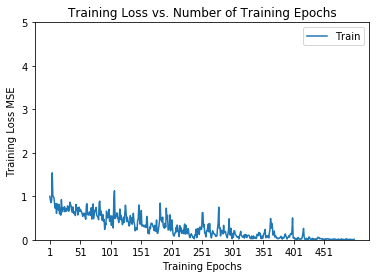

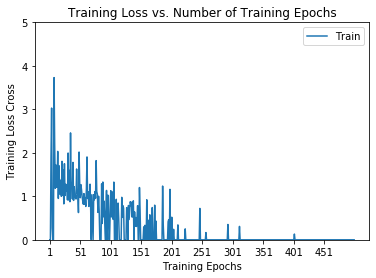

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import torch
import random

# show plot first run
%matplotlib inline 
# test autocompletion with tab or tab+shift
%config IPCompleter.greedy=True 

device = torch.device('cpu')

nn_img_size = 32
num_classes = 3
learning_rate = 0.0001
num_epochs = 500
batch_size = 4

#loss_mode = 'crossentropy' 

loss_mse_train_hist = []
loss_cross_train_hist = []

##################################################
## Please implement a two layer neural network  ##
##################################################

def relu(x):
    """ReLU activation function"""
    return torch.clamp(x, min=0.0)

def relu_derivative(output):
    """derivative of the ReLU activation function"""
    output[output <= 0] = 0
    output[output>0] = 1
    return output

def softmax(z):
    """softmax function to transform values to probabilities"""
    z -= z.max()
    z = torch.exp(z)
    sum_z = z.sum(1, keepdim=True)
    return z / sum_z 

def loss_mse(activation, y_batch):
    """mean squared loss function"""
    # use MSE error as loss function 
    # Hint: the computed error needs to get normalized over the number of samples
    loss = (activation - y_batch).pow(2).sum() 
    mse = 1.0 / activation.shape[0] * loss
    return mse

def loss_crossentropy(activation, y_batch):
    """cross entropy loss function"""
    batch_size = y_batch.shape[0]
    loss = ( - y_batch * activation.log()).sum() / batch_size
    return loss

def loss_deriv_mse(activation, y_batch):
    """derivative of the mean squared loss function"""
    dCda2 = (1 / activation.shape[0]) * (activation - y_batch)
    return dCda2

def loss_deriv_crossentropy(activation, y_batch):
    """derivative of the mean cross entropy loss function"""
    batch_size = y_batch.shape[0]
    dCda2 = activation
    dCda2[range(batch_size), np.argmax(y_batch, axis=1)] -= 1
    dCda2 /= batch_size
    return dCda2

def setup_train():
    """train function"""
    # load and resize train images in three categories
    # cars = 0, flowers = 1, faces = 2 ( true_ids )
    train_images_cars = glob.glob('./images/db/train/cars/*.jpg')
    train_images_flowers = glob.glob('./images/db/train/flowers/*.jpg')
    train_images_faces = glob.glob('./images/db/train/faces/*.jpg')
    train_images = [train_images_cars, train_images_flowers, train_images_faces]
    num_rows = len(train_images_cars)+len(train_images_flowers) +len(train_images_faces)
    X_train = torch.zeros((num_rows, nn_img_size*nn_img_size))
    y_train = torch.zeros((num_rows, num_classes))

    counter = 0
    for (label, fnames) in enumerate(train_images):
        for fname in fnames:
            #print(label, fname)
            img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (nn_img_size, nn_img_size) , interpolation=cv2.INTER_AREA)

            # print( label, " -- ", fname, img.shape)

            # fill matrices X_train - each row is an image vector
            # y_train - one-hot encoded, put only a 1 where the label is correct for the row in X_train
            y_train[counter, label] = 1
            X_train[counter] = torch.from_numpy(img.flatten().astype(np.float32))
            
            counter += 1

    # print(y_train)
    return X_train, y_train

def forward(X_batch, y_batch, W1, W2, b1, b2):
    """forward pass in the neural network """
    ### YOUR CODE ####
    # please implement the forward pass
    # 
    #print(type(X_batch))
    #print(type(W1))
    #print(type(b1))
    
    m1 = torch.mm(X_batch, W1)+b1
    #print(tmp.shape)
    #m1 = torch.add(tmp,b1)
    #print(m1.shape)
    a1 = relu(m1)
    #print(a1.shape)
    
    #m2 = torch.mm(a1, W2)+b2
    #a2 = relu(m2)
    
    # if not relu(m2) in use
    a2 = torch.mm(a1, W2)+b2
    
    #loss = torch.sum((a2 - y_batch)**2)
    lossmse = loss_mse(a2, y_batch)
    losscross = loss_crossentropy(a2, y_batch)

    # the function should return the loss and both intermediate activations
    return lossmse.numpy(), losscross.numpy(), a2, a1

def backward(a2, a1, X_batch, y_batch, W2):
    """backward pass in the neural network """
    # Implement the backward pass by computing
    # the derivative of the complete function
    # using the chain rule as discussed in the lecture
    #print('a2',a2.shape)
    #print('a1',a1.shape)
    #print('x',X_batch.shape)
    #print('y',y_batch.shape)
    #print('W2',W2.shape)
    
    # please use the appropriate loss functions 
    # YOUR CODE HERE
    # W1' = X.T * ( ( (2*(a2-yc)*relu(a2)) * W2.T ) * relu(a1) ) ## use relu(a2) or not??? no neg val can pass through
    # b1' = 1 * ( ( (2*(a2-yc)*relu(a2)) * W2.T ) * relu(a1) )
    # W2' = a1.T * 2*(a2 - yc)
    # v2' = 1 * 2*(a2 - yc)
    
    # dCostda2
    dCda2  = 2*(a2 - y_batch) # for W1 and W2
    da2dm2 = relu_derivative(a2) # for W1 and W2 
    #dm2dW2 = a1 # only for W2
    #dm2da1 = W2 # only for W1
    da1dm1 = relu_derivative(a1) # only for W1
    #dm1db1 = 1 # ignore
    #dm1dw1 = X_batch # just use X_batch
    
    # dCdW2 = (W2') = dCda2 * da2dm2 * dm2dW2
    # calc in order: dCdW2 = dm2dW2 * (dCda2 * da2dm2)  
    # fit dimension: dCdW2 = dm2dW2.T * (dCda2 * da2dm2)
   
    
    # b2' = dm1db1 * dCda2 * da2dm2  # first term is 1*
    # b2' = dCda2 * da2dm2 # mean over axis=0
    
    # dCdW1 = (W1') = dCda2 * da2dm2 * dm2da1 * da1dm1 * dm1dw1
    # calc in order: dCdW1 = X_batch * [ ((dCda2 * da2dm2)*dm2da1) * da1dm1 ]
    # fit dimension: dCdW1 = X_batch.T * [ ((dCda2 * da2dm2)*dm2da1.T) * da1dm1 ]
    
    # replace: dCdW2 = a1.T * (dCda2 * da2dm2)
    #    dCdb2 = b2' = mean_over_axis0( dCda2 * da2dm2 )
    #          dCdW1 = X_batch.T * [ ((dCda2 * da2dm2)*W2.T) * relu_derivative(a1) ]
    #    dCdb1 = b1' = mean_over_axis0( ((dCda2 * da2dm2)*W2.T) * relu_derivative(a1) )
    
    # implementation
    tmp1 = dCda2 
    #tmp1 = torch.mul(dCda2,da2dm2) # *relu_deriv element wise mult
    tmp2 = torch.mm(tmp1,W2.T)
    tmp3 = torch.mul(tmp2, da1dm1) # *relu_deriv element wise mult
    
    dCdW2 = torch.mm(a1.T,tmp1)
    dCdb2 = torch.mean( tmp1, dim=0 )
    dCdW1 = torch.mm(X_batch.T, tmp3)
    dCdb1 = torch.mean( tmp3, dim=0 )
    
    # function should return 4 derivatives with respect to
    # W1, W2, b1, b2
    return dCdW1, dCdW2, dCdb1, dCdb2

def train(X_train, y_train):
    """ train procedure """
    # for simplicity of this execise you don't need to find useful hyperparameter
    # I've done this for you already and every test image should work for the
    # given very small trainings database and the following parameters.
    #h = 1500
    h = 1500
    std = 0.0001
    # YOUR CODE HERE
    # initialize W1, W2, b1, b2 randomly
    # Note: W1, W2 should be scaled by variable std
    #W1 =  np.random.normal(0, 1.0,  h * nn_img_size**2).reshape((nn_img_size**2,h))
    #W2 =  np.random.normal(0, 1.0,  h * num_classes).reshape((h,num_classes))
    #W1 *= 1/(h * nn_img_size**2)
    #W2 *= 1/(h * num_classes)
    #print(1/(h * nn_img_size**2))
    #print(1/(h * num_classes))
    
    W1 = torch.normal(torch.zeros(nn_img_size**2,h), torch.ones(nn_img_size**2,h))
    W2 = torch.normal(torch.zeros(h,num_classes), torch.ones(h,num_classes))
    W1 *=std
    W2 *=std
    # failure in predictions
    #W1 *= 1/(h*nn_img_size**2)
    #W2 *= 1/(h*num_classes)
    
    #b1 = np.random.normal(0, 0.2, h)
    #b2 = np.random.normal(0, 0.2, num_classes)
    b1 = torch.normal(torch.zeros(h), torch.ones(h))
    b2 = torch.normal(torch.zeros(num_classes), torch.ones(num_classes))
    b1 *=std
    b2 *=std
    #failure in predictions
    #b1 *= 1/h
    #b2 *= 1/num_classes
    
    #print(b1)
    #print(b2)
    
    lenY = y_train.shape[0]
    
    # run for num_epochs
    for i in range(num_epochs):

        X_batch = None
        y_batch = None

        # use only a batch of batch_size of the training images in each run
        # sample the batch images randomly from the training set
        # YOUR CODE HERE
        idx = random.sample(range(0, lenY), batch_size)
        X_batch = X_train[idx]
        y_batch = y_train[idx]

        # forward pass for two-layer neural network using ReLU as activation function
        lossmse, losscross, a2, a1 = forward(X_batch, y_batch, W1, W2, b1, b2)

        # add loss to loss_train_hist for plotting
        loss_mse_train_hist.append(lossmse)
        
        if np.isnan(losscross):
            losscross = 1e-10
            
        loss_cross_train_hist.append(losscross)
        
        
        if i % 10 == 0:
            print("iteration %d: lossmse %f losscross %f" % (i, lossmse, losscross))

        # backward pass 
        dCdW1, dCdW2, dCdb1, dCdb2 = backward(a2, a1, X_batch, y_batch, W2)
        
        #print("dCdb2.shape:", dCdb2.shape, dCdb1.shape)

        # depending on the derivatives of W1, and W2 regaring the cost/loss
        # we need to adapt the values in the negative direction of the 
        # gradient decreasing towards the minimum
        # we weight the gradient by a learning rate
        # YOUR CODE HERE
        W1 -= learning_rate * dCdW1
        W2 -= learning_rate * dCdW2
        b1 -= learning_rate * dCdb1
        b2 -= learning_rate * dCdb2
        
    return W1, W2, b1, b2

X_train, y_train = setup_train()
W1, W2, b1, b2 = train(X_train, y_train)

# predict the test images, load all test images and 
# run prediction by computing the forward pass
test_images = []
test_images.append( (cv2.imread('./images/db/test/flower.jpg', cv2.IMREAD_GRAYSCALE), 1) )
test_images.append( (cv2.imread('./images/db/test/car.jpg', cv2.IMREAD_GRAYSCALE), 0) )
test_images.append( (cv2.imread('./images/db/test/face.jpg', cv2.IMREAD_GRAYSCALE), 2) )

for idx,ti in enumerate(test_images):
    resized_ti = cv2.resize(ti[0], (nn_img_size, nn_img_size) , interpolation=cv2.INTER_AREA)
    X_test = resized_ti.reshape(1,-1)
    #print(X_test.shape)
    # YOUR CODE HERE 
    # convert test images to pytorch
    X_test = torch.from_numpy(X_test.astype(np.float32))
    # do forward pass depending mse or softmax
    # evaluate training set accuracy
    #print(X_test.T.size())
    #print(W1.size())
    hidden_layer = torch.mm(X_test,W1)
    #print(hidden_layer.size())
    hidden_layer[hidden_layer<0] = 0
    a2_test = torch.mm(hidden_layer, W2)
    
    print("Test output (values / pred_id / true_id):", a2_test, torch.argmax(a2_test), ti[1])
    
# print("------------------------------------")
# print("Test model output Weights:", W1, W2)
# print("Test model output bias:", b1, b2)

#print(np.asarray(loss_train_hist))

plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss MSE")
plt.plot(range(1,num_epochs +1),loss_mse_train_hist,label="Train")
plt.ylim((0,5.))
plt.xticks(np.arange(1, num_epochs+1, 50.0))
plt.legend()
plt.savefig('simple_nn_train_mse.png')
plt.show()

plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss Cross")
plt.plot(range(1,num_epochs +1),loss_cross_train_hist,label="Train")
plt.ylim((0,5.))
plt.xticks(np.arange(1, num_epochs+1, 50.0))
plt.legend()
plt.savefig("simple_nn_train_cross.png")
plt.show()